# Import the Libararies

In [1]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp
# !pip install seaborn
# !pip install transformers
# !pip install pandas
# !pip install datasets

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# import keras_core as keras
# import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
print("TensorFlow version:", tf.__version__)
# print("Keras version:", keras.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.13.0


# Load the data

In [3]:
# train_prompts = pd.read_csv('train_prompts.csv') #('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
# train_essays = pd.read_csv('train_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
# test_essays = pd.read_csv('test_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
# train_extra = pd.read_csv('train_v3_drcat_01.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')
# train_extra_2 = pd.read_csv('train_v3_drcat_02.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')

train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv') #('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_extra = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')
train_extra_2 = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')

# 🐝데이터 준비 (train+extra)

Text(0.5, 1.0, 'Distribution of Generated Text')

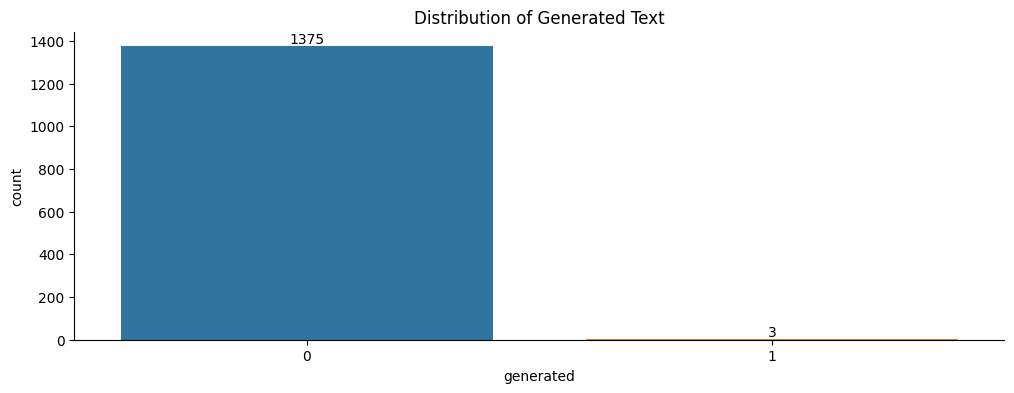

In [4]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [5]:
train_essays['text_length'] = train_essays['text'].apply(len)
train_essays.drop(['id','prompt_id'],axis=1,inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


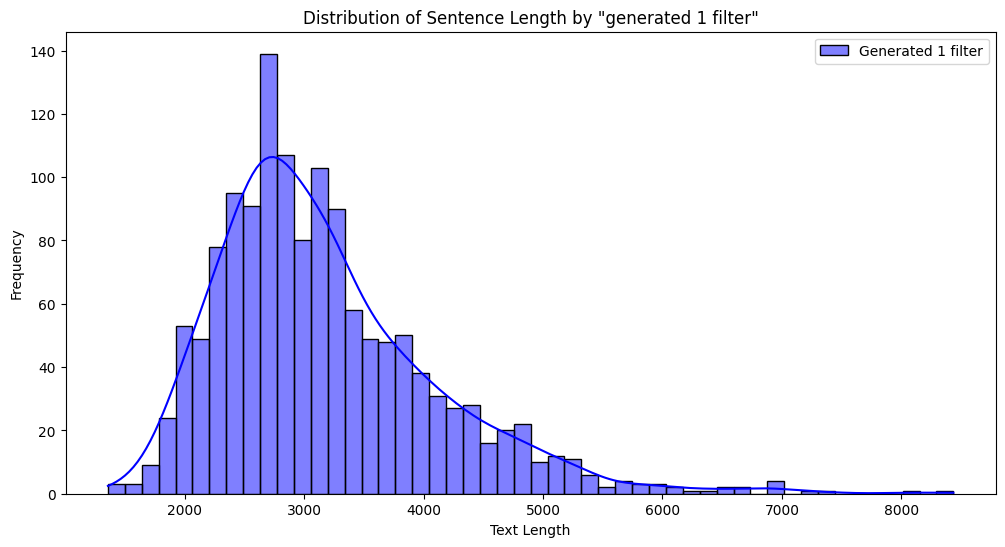

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the histogram
plt.figure(figsize=(12, 6))
sns.histplot(train_essays['text_length'], bins=50, color='blue', label='Generated 1 filter', kde=True)
plt.title('Distribution of Sentence Length by "generated 1 filter"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
train_essays = train_essays.loc[(train_essays['text_length'] >= 746) & (train_essays['text_length'] <= 6000)]
train_essays.head()

,text,generated,text_length
0,Cars. Cars have been around since they became ...,0,3289
1,Transportation is a large necessity in most co...,0,2738
2,"""America's love affair with it's vehicles seem...",0,4428
3,How often do you ride in a car? Do you drive a...,0,4013
4,Cars are a wonderful thing. They are perhaps o...,0,4698


In [8]:
train_essays.describe()

,generated,text_length
count,1362.000000,1362.000000
mean,0.002203,3125.391336
std,0.046898,829.878047
min,0.000000,1356.000000
25%,0.000000,2550.250000
50%,0.000000,2977.500000
75%,0.000000,3596.750000
max,1.000000,5977.000000


In [9]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1362 entries, 0 to 1377
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1362 non-null   object
 1   generated    1362 non-null   int64 
 2   text_length  1362 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 42.6+ KB


# ====== train_extra로부터 데이터 증강 ==========

In [10]:
df_train_extra=pd.concat([train_extra,train_extra_2],ignore_index=True)

df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [11]:
# generated 열 값이 0인 행들만 추출하여 새로운 데이터프레임 생성
df_train_extra_stu1 = df_train_extra[df_train_extra['generated'] == 1]
df_train_extra_stu0 = df_train_extra[df_train_extra['generated'] == 0]
# df_train_extra_stu = df_train_extra_stu.drop(columns=["prompt_name", "RDizzl3_seven", 'model'])

# df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['source'] == 'train_essays']

# 새로운 데이터프레임 확인
print(df_train_extra_stu1)
print(df_train_extra_stu0)

                                                     text  generated  \
25996    In recent years, technology has had a profoun...          1   
25997   I strongly believe that meditation and mindful...          1   
25998   One way school administrators can attempt to c...          1   
25999   While summer is meant as a break from the regu...          1   
26000   The use of Facial Action Coding System (FACS) ...          1   
...                                                   ...        ...   
130770  Dear Senator,\n\nI am writing to you regarding...          1   
130771  I remember the day distinctively. I was sittin...          1   
130772  Dear Senator, \n\nI am writing this letter to ...          1   
130773  Dear Senator,\n\nI am writing to urge you to e...          1   
130774  It was a typical summer afternoon in my hometo...          1   

                             prompt_name                source  RDizzl3_seven  \
25996                    Car-free cities  mistral7bins

In [12]:
# prompt가 두 주제에 해당하는 값만 저장 __ 캐글이 숨겨놓은 test set에는 다른 prompt도 있을지 모른다는 생각 존재

desired_prompts = ['Car-free cities', 'Does the electoral college work?']

df_train_extra_stu0 = df_train_extra_stu0[df_train_extra_stu0['prompt_name'].isin(desired_prompts)]
df_train_extra_stu1 = df_train_extra_stu1[df_train_extra_stu1['prompt_name'].isin(desired_prompts)]

print(df_train_extra_stu0)
print(df_train_extra_stu1)

                                                     text  generated  \
1168    Cars have been around for awhile and they have...          0   
1169    Have you ever thought what it would be like no...          0   
1170    What you are about to read is going to give yo...          0   
1171    cars have many flaws nd and in this day and ag...          0   
1172    There are many advantages of limiting car usag...          0   
...                                                   ...        ...   
108969  There has been a fuss about the Elector Colleg...          0   
108970  Limiting car usage has many advantages. Such a...          0   
108971  There's a new trend that has been developing f...          0   
108972  As we all know cars are a big part of our soci...          0   
108973  Cars have been around since the 1800's and hav...          0   

                             prompt_name           source  RDizzl3_seven  \
1168                     Car-free cities  persuade_corpus  

In [13]:
df_train_extra_stu = pd.concat([df_train_extra_stu0,df_train_extra_stu1])

df_train_extra_stu = df_train_extra_stu.drop_duplicates(subset=['text'])

In [14]:
df_train_extra_stu['text_length'] = df_train_extra_stu['text'].apply(lambda x: len(str(x)))
df_train_extra_stu.drop(['prompt_name','source','RDizzl3_seven','model'],axis=1,inplace=True)

In [15]:
df_train_extra_stu.tail()

,text,generated,text_length
130770,"Dear Senator,\n\nI am writing to you regarding...",1,2173
130771,I remember the day distinctively. I was sittin...,1,2515
130772,"Dear Senator, \n\nI am writing this letter to ...",1,2305
130773,"Dear Senator,\n\nI am writing to urge you to e...",1,2298
130774,It was a typical summer afternoon in my hometo...,1,2146


Text(0.5, 1.0, 'Distribution of Generated Text')

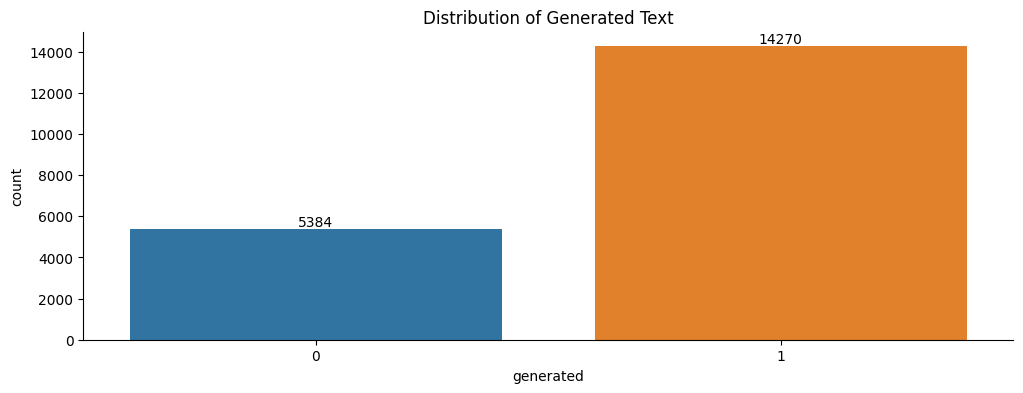

In [16]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra_stu,
                   x="generated",
                   order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


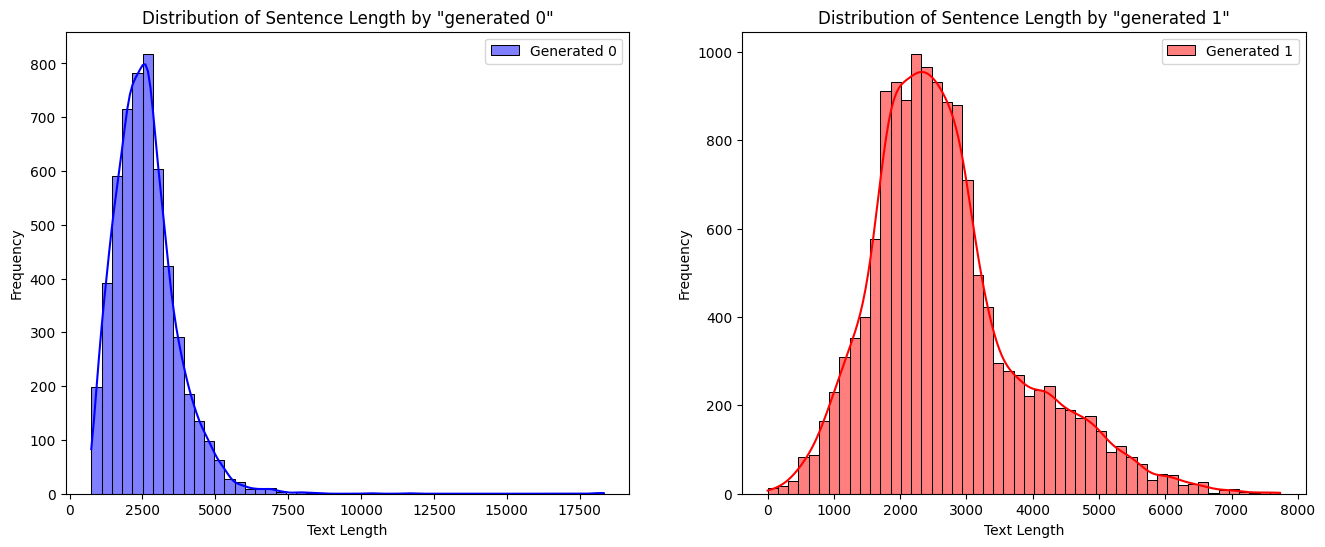

In [17]:
#Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram for 'text_length' with generated=0
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# Plot the histogram for 'text_length' with generated=1
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()

In [18]:
selected_rows1 = df_train_extra_stu[df_train_extra_stu['generated'] == 1]
selected_rows0 = df_train_extra_stu[df_train_extra_stu['generated'] == 0]
# 선택된 행들에 대해 describe를 수행합니다.
description1 = selected_rows1.describe()
description0 = selected_rows0.describe()

# 결과를 출력합니다.
print(description0)
print(description1)

       generated   text_length
count     5384.0   5384.000000
mean         0.0   2628.299777
std          0.0   1085.181957
min          0.0    746.000000
25%          0.0   1901.000000
50%          0.0   2514.500000
75%          0.0   3172.000000
max          0.0  18322.000000
       generated   text_length
count    14270.0  14270.000000
mean         1.0   2689.670988
std          0.0   1134.742021
min          1.0      1.000000
25%          1.0   1920.000000
50%          1.0   2505.000000
75%          1.0   3196.000000
max          1.0   7729.000000


In [19]:
# Filter the DataFrame for rows where text_length is between 50 and 6000
filtered_rows0 = selected_rows0.loc[(selected_rows0['text_length'] >= 746) & (selected_rows0['text_length'] <= 6000)]
filtered_rows1 = selected_rows1.loc[(selected_rows1['text_length'] >= 746) & (selected_rows1['text_length'] <= 6000)]

# You can then describe the new filtered DataFrames if you want
description_filtered0 = filtered_rows0.describe()
description_filtered1 = filtered_rows1.describe()

# To see the results
print(description_filtered0)
print(description_filtered1)

       generated  text_length
count     5342.0  5342.000000
mean         0.0  2589.022651
std          0.0   967.391436
min          0.0   746.000000
25%          0.0  1896.250000
50%          0.0  2498.000000
75%          0.0  3148.750000
max          0.0  5996.000000
       generated   text_length
count    13899.0  13899.000000
mean         1.0   2679.338442
std          0.0   1041.837382
min          1.0    747.000000
25%          1.0   1939.000000
50%          1.0   2508.000000
75%          1.0   3175.000000
max          1.0   5999.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


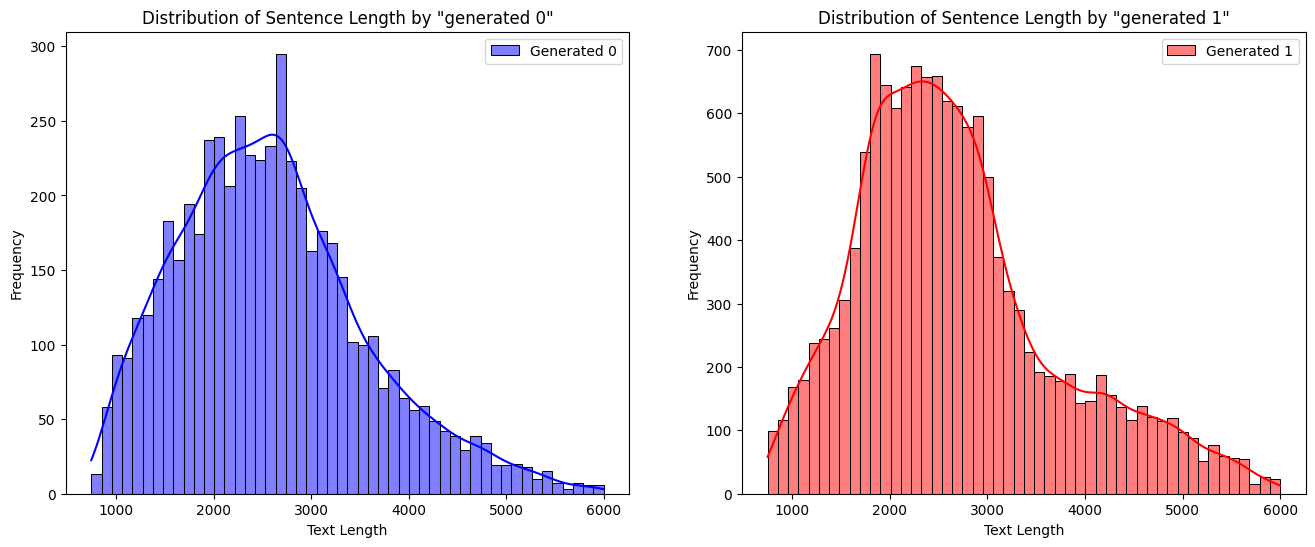

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram for 'text_length' with generated=0
sns.histplot(filtered_rows0[filtered_rows0['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# Plot the histogram for 'text_length' with generated=1
sns.histplot(filtered_rows1[filtered_rows1['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()

# =====df_train_essays_final 데이터셋 준비=======

In [21]:
df_train_essays_final = pd.concat([train_essays,filtered_rows0,filtered_rows1],axis=0)

Text(0.5, 1.0, 'Distribution of Generated Text')

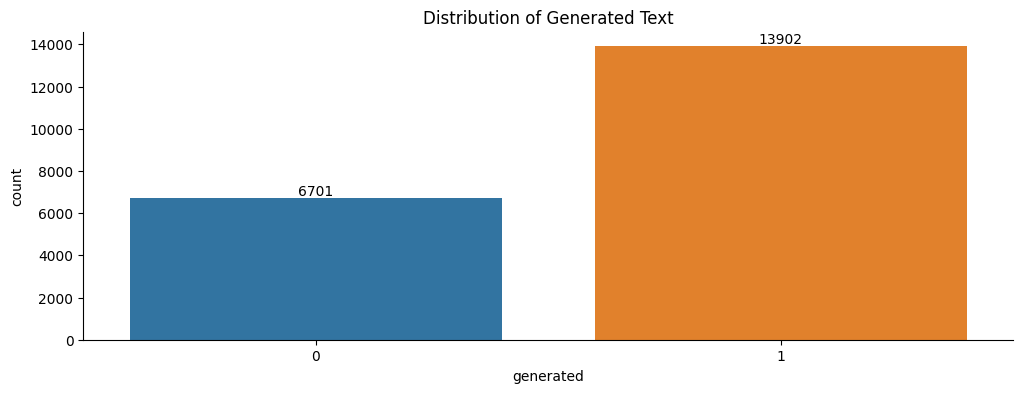

In [22]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated",
                   order=df_train_essays_final['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_essays_final['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


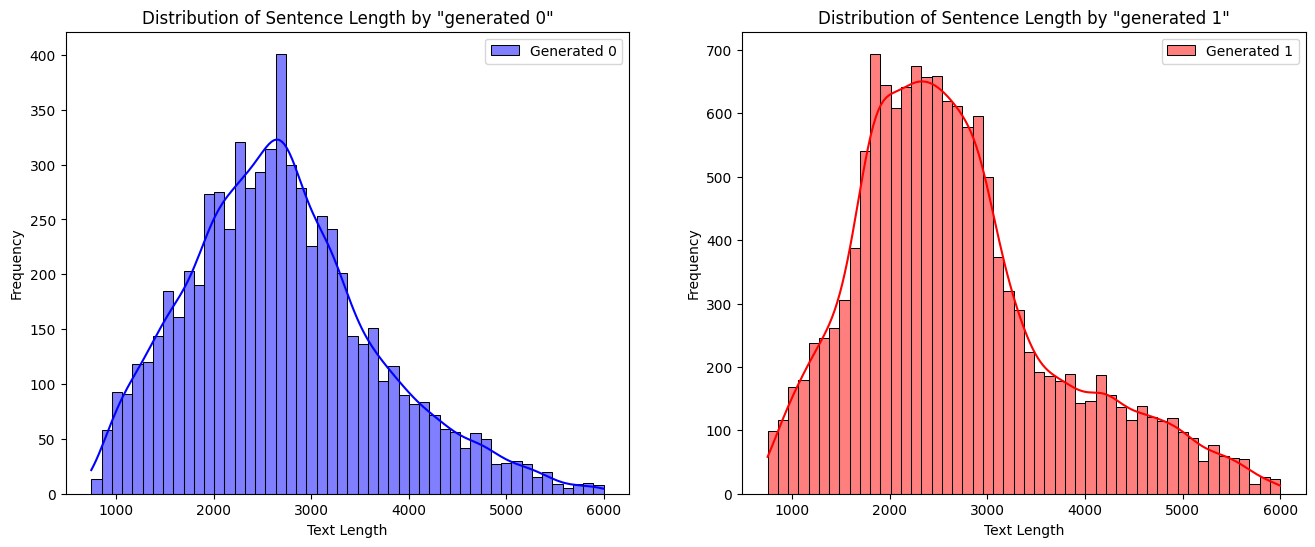

In [23]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram for 'text_length' with generated=0
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# Plot the histogram for 'text_length' with generated=1
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()

In [24]:
df_train_essays_final.drop(['text_length'],axis=1,inplace=True)

In [25]:
df_train_essays_final.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [26]:
df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20603 entries, 0 to 130774
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20603 non-null  object
 1   generated  20603 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 482.9+ KB


In [27]:
df_train_essays_final.size

41206

In [28]:
df_train_essays_final['text'][:5]

0    Cars. Cars have been around since they became ...
1    Transportation is a large necessity in most co...
2    "America's love affair with it's vehicles seem...
3    How often do you ride in a car? Do you drive a...
4    Cars are a wonderful thing. They are perhaps o...
Name: text, dtype: object

In [29]:
df_train_essays_final.reset_index(drop=True, inplace=True)

In [30]:
df_train_essays_final.tail

<bound method NDFrame.tail of                                                     text  generated
0      Cars. Cars have been around since they became ...          0
1      Transportation is a large necessity in most co...          0
2      "America's love affair with it's vehicles seem...          0
3      How often do you ride in a car? Do you drive a...          0
4      Cars are a wonderful thing. They are perhaps o...          0
...                                                  ...        ...
20598  Dear Senator,\n\nI am writing to you regarding...          1
20599  I remember the day distinctively. I was sittin...          1
20600  Dear Senator, \n\nI am writing this letter to ...          1
20601  Dear Senator,\n\nI am writing to urge you to e...          1
20602  It was a typical summer afternoon in my hometo...          1

[20603 rows x 2 columns]>

# punctuation 날리기

In [ ]:
# import string
# print(string.punctuation)
# print(type(string.punctuation))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

<class 'str'>


In [ ]:
# punctuation 날리기
# df_train_essays_final['text'] = df_train_essays_final['text'].apply(lambda x: ''.join([k for k in x if k not in string.punctuation]))

0         Cars Cars have been around since they became f...
1         Transportation is a large necessity in most co...
2         Americas love affair with its vehicles seems t...
3         How often do you ride in a car Do you drive a ...
4         Cars are a wonderful thing They are perhaps on...
                                ...                        
130770    Dear Senator\n\nI am writing to you regarding ...
130771    I remember the day distinctively I was sitting...
130772    Dear Senator \n\nI am writing this letter to e...
130773    Dear Senator\n\nI am writing to urge you to ei...
130774    It was a typical summer afternoon in my hometo...
Name: text, Length: 20603, dtype: object

# BPE Tokenizetion : Custom

In [31]:
from tokenizers import(
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from transformers import PreTrainedTokenizerFast

from datasets import Dataset
from tqdm.auto import tqdm
from tokenizers import processors

In [74]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [164]:
# Tokenizer 초기화
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Normalizer 설정
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])

# Pre-tokenizer 설정: Byte-Level pre-tokenizer를 사용
# "Ġ" 문자 제거 하고 싶다면 -> add_prefix_space=False 추가
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# BPE Trainer 설정 및 스페셜 토큰 추가
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

# 데이터셋 로드 및 토크나이저 훈련 (훈련 셋 : df_train_essays_final[['text']])
dataset = Dataset.from_pandas(df_train_essays_final[['text']])
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

# PreTrainedTokenizerFast로 래핑
from transformers import RobertaTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [72]:
# Post-Processor 및 Decoder 설정 (추가 코딩 필요한지 고민)
# tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
# tokenizer.decoder = decoders.ByteLevel()

# cls_token_id = tokenizer.token_to_id("[CLS]")
# sep_token_id = tokenizer.token_to_id("[SEP]")

# tokenizer.post_processor = processors.TemplateProcessing(
#     single="[CLS] $A [SEP]",
#     pair="[CLS] $A [SEP] $B:1 [SEP]:1",
#     special_tokens=[
#         ("[CLS]", cls_token_id),
#         ("[SEP]", sep_token_id),
#     ],
# )

In [165]:
# "[UNK]" 토큰의 정수 ID 확인
unk_token_id = tokenizer.convert_tokens_to_ids("[UNK]")

# "[PAD]" 토큰의 정수 ID 확인
pad_token_id = tokenizer.convert_tokens_to_ids("[PAD]")

# "[CLS]" 토큰의 정수 ID 확인
cls_token_id = tokenizer.convert_tokens_to_ids("[CLS]")

# "[SEP]" 토큰의 정수 ID 확인
sep_token_id = tokenizer.convert_tokens_to_ids("[SEP]")

# "[MASK]" 토큰의 정수 ID 확인
mask_token_id = tokenizer.convert_tokens_to_ids("[MASK]")

print("[UNK] 토큰의 정수 ID:", unk_token_id)
print("[PAD] 토큰의 정수 ID:", pad_token_id)
print("[CLS] 토큰의 정수 ID:", cls_token_id)
print("[SEP] 토큰의 정수 ID:", sep_token_id)
print("[MASK] 토큰의 정수 ID:", mask_token_id)

[UNK] 토큰의 정수 ID: 0
[PAD] 토큰의 정수 ID: 1
[CLS] 토큰의 정수 ID: 2
[SEP] 토큰의 정수 ID: 3
[MASK] 토큰의 정수 ID: 4


In [166]:
text = ["Let's test this tokenizer.", "Nice to meet you"]
tokens = tokenizer.encode(text)
print(tokens)
print(tokenizer.decode(tokens))

[4281, 384, 6779, 367, 186, 1902, 698, 188, 18, 678, 679, 186, 3518, 306]
ĠLet's Ġtest Ġthis Ġto ken iz er. ĠN ice Ġto Ġmeet Ġyou


In [167]:
tokens = tokenizer.tokenize(text)
print(tokens)

['ĠLet', "'s", 'Ġtest', 'Ġthis', 'Ġto', 'ken', 'iz', 'er', '.', 'ĠN', 'ice', 'Ġto', 'Ġmeet', 'Ġyou']


In [168]:
encoding = tokenizer.encode_plus(text, return_tensors="tf")
print(encoding)

{'input_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=
array([[4281,  384, 6779,  367,  186, 1902,  698,  188,   18,  678,  679,
         186, 3518,  306]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [86]:
# 사용 XX

# from tqdm import tqdm
# import numpy as np

# max_length = 256  # 최대 시퀀스 길이 설정
# input_ids = []
# attention_masks = []

# for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
#     encoded = tokenizer.encode(text, add_special_tokens=True)

#     # 최대 길이에 맞게 시퀀스 자르기
#     input_id = encoded.ids[:max_length]
#     attention_mask = encoded.attention_mask[:max_length]

#     # 패딩 적용
#     padding_length = max_length - len(input_id)
#     input_ids.append(input_id + [0] * padding_length)
#     attention_masks.append(attention_mask + [0] * padding_length)

# # NumPy 배열로 변환
# input_ids = np.array(input_ids)
# attention_masks = np.array(attention_masks)

# # 토큰화된 데이터를 pandas DataFrame으로 변환
# df_encoded_BPE = pd.DataFrame({
#     'input_ids': list(input_ids),
#     'attention_mask': list(attention_masks)
# })

토큰화 진행중: 100%|██████████| 20603/20603 [00:35<00:00, 584.73it/s]


In [97]:
# df_encoded_BPE.head()

,input_ids,attention_mask
0,"[1, 2389, 18, 844, 291, 610, 846, 1252, 366, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[1, 7887, 214, 163, 809, 3917, 197, 609, 1692,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[1, 6, 7368, 384, 3467, 5953, 326, 244, 384, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[1, 6983, 1239, 473, 305, 2013, 197, 163, 224,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[1, 2389, 253, 163, 6671, 969, 18, 1024, 253, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [98]:
# df_encoded_BPE.dtypes

input_ids         object
attention_mask    object
dtype: object

In [155]:
# df_train_essays_final['text'] 토큰화 해보기
# test_essays 데이터의 토큰화 진행 상황을 표시
test_input_ids = []
test_attention_masks = []

for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=256, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')

    test_input_ids.append(encoded['input_ids'][0])
    test_attention_masks.append(encoded['attention_mask'][0])
    # 토큰화된 데이터를 pandas DataFrame으로 변환
test_input = pd.DataFrame({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
})

토큰화 진행중:   0%|          | 0/20603 [00:00<?, ?it/s]

In [156]:
test_input.head()

,input_ids,attention_mask
0,"[827, 18, 827, 292, 612, 847, 1267, 366, 3820,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[3348, 214, 163, 810, 3916, 197, 611, 1693, 30...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[426, 7962, 384, 3465, 5950, 326, 244, 384, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[3658, 1239, 472, 306, 2012, 197, 163, 224, 35...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[827, 254, 163, 6672, 969, 18, 1023, 254, 6473...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [157]:
test_input.dtypes

input_ids         object
attention_mask    object
dtype: object

# BPE 토크나이저 - RobertaTokenizer

In [ ]:
# BERT 토크나이저 초기화
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# BPE 토크나이저로 RoBERTa 훈련 (아직 적용 x)

In [110]:
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split

model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

# 데이터프레임에서 필요한 열만 선택
df_encoded_BPE = df_encoded_BPE[['input_ids', 'attention_mask']]

# 'generated' 열은 레이블로 사용할 것이므로 따로 선택
labels = df_train_essays_final['generated'].values
print("df_encoded shape:", df_encoded_BPE.shape)
print("labels shape:", labels.shape)
print("labels shape:", labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

df_encoded shape: (20603, 2)
labels shape: (20603,)
labels shape: [0 0 0 ... 1 1 1]


In [111]:
# 학습 및 검증 데이터셋 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df_encoded_BPE, labels, random_state=2018, test_size=0.2)

# 클래스 분포 확인을 위한 데이터프레임 생성
train_df = pd.DataFrame({"Data Split": ["Train"] * len(train_labels), "Labels": train_labels})
validation_df = pd.DataFrame({"Data Split": ["Validation"] * len(validation_labels), "Labels": validation_labels})
combined_df = pd.concat([train_df, validation_df])

# 데이터셋 준비
train_inputs = {
    "input_ids": np.array(train_inputs["input_ids"].to_list()),
    "attention_mask": np.array(train_inputs["attention_mask"].to_list())
}
train_labels = np.array(train_labels)

validation_inputs = {
    "input_ids": np.array(validation_inputs["input_ids"].to_list()),
    "attention_mask": np.array(validation_inputs["attention_mask"].to_list())
}
validation_labels = np.array(validation_labels)

print("train_inputs shape:", train_inputs["input_ids"].shape)
print("validation_inputs shape:", validation_inputs["input_ids"].shape)
print("train_labels shape:", train_labels.shape)
print("validation_labels shape:", validation_labels.shape)

train_inputs shape: (16482, 256)
validation_inputs shape: (4121, 256)
train_labels shape: (16482,)
validation_labels shape: (4121,)


In [112]:
import string
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# # 문자열을 정수 리스트로 변환하는 함수
# def convert_string_to_int_array(string_array):
#     int_arrays = []
#     for string in string_array:
#         # 문자열을 정수 리스트로 변환
#         int_list = [int(i) for i in string.split() if i.isdigit()]
#         int_arrays.append(int_list)
#     return np.array(int_arrays, dtype=int)

# # 'attention_mask'의 문자열을 정수 배열로 변환
# train_inputs['attention_mask'] = convert_string_to_int_array(train_inputs['attention_mask'])
# validation_inputs['attention_mask'] = convert_string_to_int_array(validation_inputs['attention_mask'])

# 변환 후 데이터 타입 재확인
print("After conversion - train_inputs[attention_mask] type:", train_inputs['attention_mask'].dtype)
print("After conversion - validation_inputs[attention_mask] type:", validation_inputs['attention_mask'].dtype)

After conversion - train_inputs[attention_mask] type: int64
After conversion - validation_inputs[attention_mask] type: int64


In [113]:
# 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", train_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("validation_inputs[input_ids] shape:", validation_inputs['input_ids'].shape)
print("validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

train_inputs[input_ids] shape: (16482, 256)
train_inputs[attention_mask] shape: (16482, 256)
validation_inputs[input_ids] shape: (4121, 256)
validation_inputs[attention_mask] shape: (4121, 256)


In [114]:
# # attention_mask에 패딩 추가
# train_inputs['attention_mask'] = np.pad(train_inputs['attention_mask'], 
#                                         ((0, 0), (0, 2)),  # (데이터 시작부터 끝까지, 2개 패딩 추가)
#                                         mode='constant',
#                                         constant_values=0)

# validation_inputs['attention_mask'] = np.pad(validation_inputs['attention_mask'],
#                                              ((0, 0), (0, 2)),
#                                              mode='constant',
#                                              constant_values=0)

# 변환 후 데이터 형상 재확인
print("After padding - train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("After padding - validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

After padding - train_inputs[attention_mask] shape: (16482, 256)
After padding - validation_inputs[attention_mask] shape: (4121, 256)


In [115]:
from keras.callbacks import ModelCheckpoint

# 배치 크기 설정
batch_size = 8

# 체크포인트 파일 경로 설정
checkpoint_path = "best_model"

# ModelCheckpoint 콜백 생성 (Tensorflow SavedModel 포맷으로 저장)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_format="tf")

# 모델 학습 시도하면서 콜백 추가
history = model.fit(
    train_inputs,
    train_labels,
    epochs=5,
    batch_size=batch_size,
    validation_data=(validation_inputs, validation_labels),
    callbacks=[checkpoint]
)

Epoch 1/5
2061/2061 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9499
Epoch 1: val_loss improved from inf to 0.02337, saving model to best_model
2061/2061 [==============================] - 753s 327ms/step - loss: 0.1245 - accuracy: 0.9499 - val_loss: 0.0234 - val_accuracy: 0.9913
Epoch 2/5
2061/2061 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9886
Epoch 2: val_loss did not improve from 0.02337
2061/2061 [==============================] - 609s 296ms/step - loss: 0.0367 - accuracy: 0.9886 - val_loss: 0.0280 - val_accuracy: 0.9913
Epoch 3/5
2061/2061 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9909
Epoch 3: val_loss did not improve from 0.02337
2061/2061 [==============================] - 608s 295ms/step - loss: 0.0324 - accuracy: 0.9909 - val_loss: 0.0779 - val_accuracy: 0.9823
Epoch 4/5
2061/2061 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9840
Epoch 4: val_loss did not improv

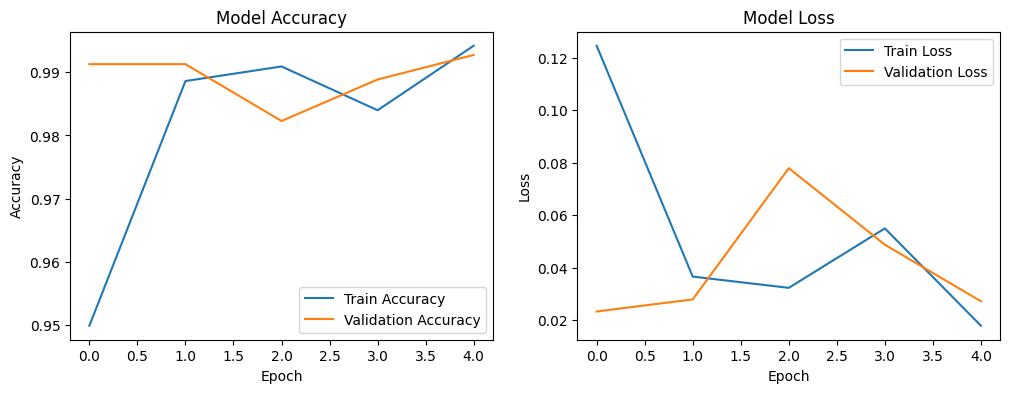

In [116]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [125]:
from tensorflow.keras.models import load_model
# 저장된 최고의 모델을 불러옴
best_model = load_model(checkpoint_path)

# test_essays 데이터의 토큰화 진행 상황을 표시
test_input_ids = []
test_attention_masks = []

for text in tqdm(test_essays['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode(text, add_special_tokens=True)

    # 최대 길이에 맞게 시퀀스 자르기
    input_id = encoded.ids[:max_length]
    attention_mask = encoded.attention_mask[:max_length]

    # 패딩 적용
    padding_length = max_length - len(input_id)
    test_input_ids.append(input_id + [0] * padding_length)
    test_attention_masks.append(attention_mask + [0] * padding_length)

    # 토큰화된 데이터를 pandas DataFrame으로 변환
test_input = pd.DataFrame({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
})

# # 문자열을 정수 리스트로 변환하는 함수
# def convert_string_to_int_list(string):
#     try:
#         # 줄바꿈, 대괄호 제거 및 쉼표로 분리
#         cleaned_string = string.replace('\n', '').replace('[', '').replace(']', '')
#         int_list = [int(i) for i in cleaned_string.split() if i.isdigit()]
#         return int_list
#     except:
#         return []  # 변환에 실패한 경우 빈 리스트 반환

# # 데이터프레임의 'input_ids' 열 변환
# test_input['input_ids'] = test_input['input_ids'].apply(convert_string_to_int_list)


# test_inputs = {
#     "input_ids": np.array(test_input["input_ids"].to_list()),
#     "attention_mask": np.array(test_input["attention_mask"].to_list())
# }

토큰화 진행중: 100%|██████████| 3/3 [00:00<00:00, 1421.64it/s]


In [126]:
def convert_string_to_int_list(string):
    try:
        # 줄바꿈, 대괄호 제거 및 쉼표로 분리
        cleaned_string = string.replace('\n', '').replace('[', '').replace(']', '')
        int_list = [int(i) for i in cleaned_string.split() if i.isdigit()]
        return int_list
    except:
        return []  # 변환에 실패한 경우 빈 리스트 반환

# 데이터프레임의 'input_ids' 열 변환
test_input['input_ids'] = test_input['input_ids'].apply(convert_string_to_int_list)


test_inputs = {
    "input_ids": np.array(test_input["input_ids"].to_list()),
    "attention_mask": np.array(test_input["attention_mask"].to_list())
}

In [128]:
def convert_string_to_int_array(string_array):
    int_arrays = []
    for string in string_array:
        # 문자열을 정수 리스트로 변환
        int_list = [int(i) for i in string.split() if i.isdigit()]
        int_arrays.append(int_list)
    return np.array(int_arrays, dtype=int)

# 'attention_mask'의 문자열을 정수 배열로 변환
#test_inputs['attention_mask'] = convert_string_to_int_array(test_inputs['attention_mask'])



# 변환 후 데이터 타입 재확인
print("After conversion - test_inputs[input_ids] type:", test_inputs['input_ids'].dtype)
print("After conversion - test_inputs[attention_mask] type:", test_inputs['attention_mask'].dtype)

After conversion - test_inputs[input_ids] type: float64
After conversion - test_inputs[attention_mask] type: int64


In [130]:
    # 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", test_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", test_inputs['attention_mask'].shape)
# attention_mask에 패딩 추가
test_inputs['attention_mask'] = np.pad(test_inputs['attention_mask'], 
                                        ((0, 0), (0, 2)),  # (데이터 시작부터 끝까지, 2개 패딩 추가)
                                        mode='constant',
                                        constant_values=0)


# 변환 후 데이터 형상 재확인
print("After padding - test_inputs[attention_mask] shape:", test_inputs['attention_mask'].shape)

train_inputs[input_ids] shape: (3, 0)
train_inputs[attention_mask] shape: (3, 256)
After padding - test_inputs[attention_mask] shape: (3, 258)


In [123]:

# 변환 후 데이터 타입 재확인
print("After conversion - test_inputs[input_ids] type:", test_inputs['input_ids'].dtype)
print("After conversion - test_inputs[attention_mask] type:", test_inputs['attention_mask'].dtype)


    # 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", test_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", test_inputs['attention_mask'].shape)


After conversion - test_inputs[input_ids] type: float64
After conversion - test_inputs[attention_mask] type: int64
train_inputs[input_ids] shape: (3, 0)
train_inputs[attention_mask] shape: (3, 256)


In [133]:
# 모델에 입력하여 예측 수행
predictions = best_model.predict(test_inputs['input_ids'], test_inputs['attention_mask'])
#predictions = best_model.predict([test_input_ids, test_attention_masks])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# WordPiece 토크나이저

In [179]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from datasets import Dataset

In [ ]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [180]:
# WordPiece 토크나이저 초기화 및 훈련
w_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

# Normalizer 설정
w_tokenizer.normalizer = normalizers.BertNormalizer(lowercase=LOWERCASE)
# tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])

# Pre-tokenizer 설정: BertPreTokenizer를 사용
w_tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

# WordPiece Trainer 설정 및 스페셜 토큰 추가
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

# 데이터셋 로드 및 토크나이저 훈련 (훈련 셋 : df_train_essays_final[['text']])
dataset = Dataset.from_pandas(df_train_essays_final[['text']])
def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
w_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

# PreTrainedTokenizerFast 래핑
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=w_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [171]:
# print(w_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))
# print(w_tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer."))

Héllò hôw are ü?
[('Let', (0, 3)), ("'", (3, 4)), ('s', (4, 5)), ('test', (6, 10)), ('my', (11, 13)), ('pre', (14, 17)), ('-', (17, 18)), ('tokenizer', (18, 27)), ('.', (27, 28))]


In [39]:
# encoding = w_tokenizer.encode("Let's test this tokenizer")
# print(encoding.tokens)

['let', "'", 's', 'test', 'this', 'toke', '##n', '##ize', '##r']


In [40]:
# cls_token_id = w_tokenizer.token_to_id("[CLS]")
# sep_token_id = w_tokenizer.token_to_id("[SEP]")
# print(cls_token_id, sep_token_id)

2 3


In [41]:
# 토크나이저 설정
# w_tokenizer.post_processor = processors.TemplateProcessing(
#     single=f"[CLS]:0 $A:0 [SEP]:0",
#     pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
#     special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)]
# )

In [42]:
# encoding = w_tokenizer.encode("Let's test this tokenizer.")
# print(encoding.tokens)
# encoding = w_tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences.")
# print(encoding.tokens)
# print(encoding.type_ids)
# w_tokenizer.decoder = decoders.WordPiece(prefix="##")
# print(tokenizer.decode(encoding.ids))

['[CLS]', 'let', "'", 's', 'test', 'this', 'toke', '##n', '##ize', '##r', '.', '[SEP]']
['[CLS]', 'let', "'", 's', 'test', 'this', 'toke', '##n', '##ize', '##r', '...', '[SEP]', 'on', 'a', 'pair', 'of', 'sentences', '.', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
let ' s test this tokenizer... on a pair of sentences.


In [174]:
text = ["Let's test this tokenizer.", "Nice to meet you"]
tokens = wrapped_tokenizer.encode(text)
print(tokens)
print(wrapped_tokenizer.decode(tokens))

[3439, 11, 86, 4928, 430, 19148, 171, 1242, 168, 18, 27022, 270, 2524, 367]
Let's test this toke ##n ##ize ##r. Nice to meet you


In [177]:
tokens = wrapped_tokenizer.encode_plus(text)
print(tokens)
print(wrapped_tokenizer.decode(tokens['input_ids']))

{'input_ids': [3439, 11, 86, 4928, 430, 19148, 171, 1242, 168, 18, 27022, 270, 2524, 367], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Let's test this toke ##n ##ize ##r. Nice to meet you


In [178]:
tokens = wrapped_tokenizer.tokenize(text)
print(tokens)

['Let', "'", 's', 'test', 'this', 'toke', '##n', '##ize', '##r', '.', 'Nice', 'to', 'meet', 'you']


In [181]:
# df_train_essays_final['text'] 토큰화 해보기
# test_essays 데이터의 토큰화 진행 상황을 표시
w_test_input_ids = []
w_test_attention_masks = []

for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
    encoded = wrapped_tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=256, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')

    w_test_input_ids.append(encoded['input_ids'][0])
    w_test_attention_masks.append(encoded['attention_mask'][0])
    # 토큰화된 데이터를 pandas DataFrame으로 변환
w_test_input = pd.DataFrame({
    'input_ids': w_test_input_ids,
    'attention_mask': w_test_attention_masks
})

토큰화 진행중:   0%|          | 0/20603 [00:00<?, ?it/s]

In [182]:
w_test_input.head()

,input_ids,attention_mask
0,"[823, 18, 823, 357, 664, 893, 1300, 429, 3711,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[3124, 289, 68, 848, 3804, 279, 654, 1708, 300...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[6, 1318, 11, 86, 3359, 5640, 385, 311, 11, 86...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[3295, 1268, 519, 367, 1969, 279, 68, 297, 35,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[823, 320, 68, 6343, 1016, 18, 1044, 320, 6006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


# Wordpiece 토크나이저 - BertTokenizer

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Wordpiece 토크나이저 - DistilBertTokenizer

In [ ]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

from transformers import TFDistilBertModel

model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')



# WordPiece 토크나이저로 DistilBERT 학습 (아직 적용 x)

In [72]:
# import tensorflow as tf
# import pandas as pd
# from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score


# # WordPiece 토크나이저 로드 (이미 로드한 코드 사용)
# tokenizer = wrapped_tokenizer  # 이미 로드한 WordPiece 토크나이저를 사용

# # 데이터 전처리
# X = df_train_essays_final['text'].values
# y = df_train_essays_final['generated'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 토큰화 및 패딩
# X_train_encoded = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf")
# X_test_encoded = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf")

# # token_type_ids를 제거합니다.
# X_train_encoded = {key: val for key, val in X_train_encoded.items() if key != 'token_type_ids'}
# X_test_encoded = {key: val for key, val in X_test_encoded.items() if key != 'token_type_ids'}

# # 모델 정의
# model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)  # 2는 이진 분류의 경우입니다.

# # 옵티마이저 설정
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# # 모델 컴파일
# model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# # 학습
# batch_size = 8
# epochs = 5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']

- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).

Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']

You sho

In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras_nlp
import keras

x_train, x_test ,y_train , y_test = train_test_split(df_train_essays_final.iloc[:,0:2], df_train_essays_final['generated'],test_size=0.2)


In [65]:
# 각 에세이의 평균 길이 계산
len_train = []

for i in range(x_train.shape[0]):
    len_train.append(len(x_train.iloc[i,0]))
print('average characters per essay are ' , np.mean(len_train))

average characters per essay are  2684.7028879990294


In [67]:
x_train.groupby('generated').count()

,text
generated,
0,5307
1,11175


In [68]:
preprocessor1 = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=512,
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=1,
)

classifier.backbone.trainable = False

classifier.compile(
    loss=['binary_crossentropy'],
    optimizer=keras.optimizers.Adam(1e-4),
    jit_compile=True,
    metrics = ['accuracy','AUC']
)


classifier.fit(x= x_train['text'].to_list(), y=x_train['generated'], batch_size=8 ,epochs =2,
               validation_data = (x_test['text'].to_list(),x_test['generated']))

Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(

Epoch 1/2
2061/2061 [==============================] - 203s 92ms/step - loss: 0.1133 - accuracy: 0.9646 - auc: 0.9937 - val_loss: 0.1764 - val_accuracy: 0.9515 - val_auc: 0.9899
Epoch 2/2
2061/2061 [==============================] - 178s 86ms/step - loss: 0.1644 - accuracy: 0.9725 - auc: 0.9908 - val_loss: 0.1557 - val_accuracy: 0.9568 - val_auc: 0.9917


In [1]:
# WordPiece 토크나이저 로드 (이미 로드한 코드 사용)
tokenizer = wrapped_tokenizer  # 이미 로드한 WordPiece 토크나이저를 사용

# 사용자 정의 토크나이저를 사용하여 데이터 토큰화
def tokenize_data(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")

x_train, x_test ,y_train , y_test = train_test_split(df_train_essays_final.iloc[:,0:2], df_train_essays_final['generated'],test_size=0.2)

# 훈련 및 테스트 데이터 토큰화
X_train_tokenized = tokenize_data(x_train['text'].to_list(), wrapped_tokenizer)
X_test_tokenized = tokenize_data(x_test['text'].to_list(), wrapped_tokenizer)

NameError: name 'wrapped_tokenizer' is not defined

In [ ]:
# 모델 학습
history = classifier.fit(
    x={'input_ids': X_train_tokenized['input_ids'], 'attention_mask': X_train_tokenized['attention_mask']},  # input_ids와 attention_mask 사용
    y=y_train,
    validation_data=({'input_ids': X_test_tokenized['input_ids'], 'attention_mask': X_test_tokenized['attention_mask']}, y_test),
    batch_size=8,
    epochs=2
)


In [ ]:
# DistilBERT 모델 설정
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# 토크나이징 함수 정의
def tokenize_function(examples):
    return tokenizer.encode_batch(examples["text"], add_special_tokens=True)

# 데이터셋 토큰화
tokenized_datasets = dataset_for_training.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("generated", "labels")

# 학습 설정

In [47]:
# 필요한 라이브러리 임포트
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf
from tokenizers import Tokenizer
import numpy as np
import pandas as pd

# 직접 훈련한 wrapped_tokenizer 토크나이저 로딩
tokenizer = wrapped_tokenizer

# DistilBERT 모델 설정
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')


# 데이터 로딩 및 전처리
texts = df_train_essays_final['text'].tolist()
labels = df_train_essays_final['generated'].tolist()  # 0 또는 1의 레이블

# 토크나이징 및 인코딩
encodings = [tokenizer.encode(text, add_special_tokens=True) for text in texts]
input_ids = [encoding.ids for encoding in encodings]
attention_masks = [encoding.attention_mask for encoding in encodings]

# 패딩
max_length = max([len(input_id) for input_id in input_ids])
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=max_length, padding='post')
attention_masks = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, maxlen=max_length, padding='post')

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2)

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'list' object has no attribute 'ids'

In [ ]:
# 모델 학습
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=64)